Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.preprocessing import normalize
from scipy.special import expit as sigmoid
import sklearn.metrics as metrics

Data loading and preprocessing

In [2]:
csv_path = "/home/jens/masterRepo/test/dataset/analysis_of_tp_and_fp.csv"
df = pd.read_csv(csv_path, dtype = {"objName":"category"})
df["visibleInlierFrac"] = df["visibleInliers"]/df["visiblePoints"]
df["visiblePointsFrac"] = df["visiblePoints"]/df["objectPoints"]
df["penetration"] = df[["penetrationInternal","penetrationExternal"]].max(axis=1)
df["intersectingInliers"] = df[["intersectingInliersInternal","intersectingInliersExternal"]].max(axis=1)
df["intersectingInliersFrac"] = df["intersectingInliers"] / df["visibleInliers"]

Logistic Regression on Individual Pr Object factors

In [8]:

def makeList(obj):
    if type(obj) is not list:
        obj = [obj]
    return obj
def get_data_for_logistic_regression(df,objects,factors,normalize_factors=True):
    objects = makeList(objects)
    factors = makeList(factors)
    obj_df = df[df["objName"].isin(objects)]
    X = obj_df[factors].values
    if len(X.shape)==1:
        X = np.expand_dims(X,axis=1)
    if normalize_factors:
        X = normalize(X,axis=0,norm="max")

    y = np.expand_dims(obj_df.g.values,axis=1)

    return X, y

def binary_logistic_regession_individual_factors(df,objects = ["AngleTubes","Ears","Gameboys"], factors= ["scoreFrac","visibleInlierFrac","visiblePointsFrac"],normalize_factors=True):
    objects = makeList(objects)
    factors = makeList(factors)
    models = {}
    result_dict = {"objName":[],"factor":[],"accuracy":[],"precision":[],"recall":[],"f1":[],"n_posetives":[],"n_negatives":[]}
    for obj in objects:
        for factor in factors:
            X,y = get_data_for_logistic_regression(df,obj,factor,normalize_factors)
            model = LogisticRegressionCV(solver='newton-cg', random_state=42).fit(X, y)
            models[obj+":"+factor] = model
            classification_report = metrics.classification_report(y,model.predict(X),output_dict=True)
            result_dict["objName"].append(obj)
            result_dict["factor"].append(factor)
            result_dict["accuracy"].append(classification_report["accuracy"])
            result_dict["precision"].append(classification_report["1"]["precision"])
            result_dict["recall"].append(classification_report["1"]["recall"])
            result_dict["f1"].append(classification_report["1"]["f1-score"])
            result_dict["n_posetives"].append(classification_report["1"]["support"])
            result_dict["n_negatives"].append(classification_report["0"]["support"])
    
    result_df = pd.DataFrame(result_dict)

    return models, result_df

def binary_logistic_regession(df,objects = ["AngleTubes","Ears","Gameboys"], factors= ["scoreFrac","visibleInlierFrac","visiblePointsFrac"],normalize_factors=True):
    objects = makeList(objects)
    factors = makeList(factors)
    models = {}
    result_dict = {"objName":[],"accuracy":[],"precision":[],"recall":[],"f1":[],"n_posetives":[],"n_negatives":[]}
    for factor in factors:
        result_dict[factor+"_w"]=[]
    result_dict[intercept]=[]
    
    for obj in objects:
        X,y = get_data_for_logistic_regression(df,obj,factors,normalize_factors)
        model = LogisticRegressionCV(solver='newton-cg', random_state=42).fit(X, y)
        models[obj] = model
        classification_report = metrics.classification_report(y,model.predict(X),output_dict=True)
        result_dict["objName"].append(obj)
        result_dict["accuracy"].append(classification_report["accuracy"])
        result_dict["precision"].append(classification_report["1"]["precision"])
        result_dict["recall"].append(classification_report["1"]["recall"])
        result_dict["f1"].append(classification_report["1"]["f1-score"])
        result_dict["n_posetives"].append(classification_report["1"]["support"])
        result_dict["n_negatives"].append(classification_report["0"]["support"])
        for factor,coef in zip(factors,model.coef_[0]):
            result_dict[factor+"_w"].append(coef)
    
    result_df = pd.DataFrame(result_dict)

    return models, result_df



def logistic_regression_plots_individual_factors(df,object_names = ["AngleTubes","Ears","Gameboys"], factors= ["scoreFrac","visibleInlierFrac","visiblePointsFrac"],normalize_factors=True):
    n_objects = len(object_names)
    n_factors = len(factors)
    models = {}
    fig, axes = plt.subplots(n_factors,n_objects,figsize=(n_objects*5,n_factors*5))
    for ax_row,factor in zip(axes,factors):
        for ax, obj in zip(ax_row,object_names):
            obj_df = df[df["objName"]==obj]
            X = np.expand_dims(obj_df[factor].values,axis=1)
            if(normalize_factors):
                X = normalize(X,axis=0,norm="max")

            y = np.expand_dims(obj_df.g.values,axis=1)
            model = LogisticRegressionCV(solver='newton-cg', random_state=42).fit(X, y)
            models[obj+":"+factor] = model
            y_pred = model.predict(X)

            cm =  metrics.confusion_matrix(y,y_pred)
            X_transformed = X.dot(model.coef_.T) + model.intercept_

            sigmoid_x = np.linspace(np.min(X_transformed,axis=0), np.max(X_transformed,axis=0), 500)
            sigmoid_y = sigmoid(sigmoid_x).ravel()
            ax.plot(sigmoid_x, sigmoid_y, color='red', linewidth=3)
            ax.scatter(X_transformed, y,c=y,cmap=mpl.colors.ListedColormap(["C0","C1"]),alpha=0.1,edgecolors=None,marker='s')

            ax.axvline(x=0, ymin=0, ymax=1,ls='--',alpha=0.75,color="C2")
            ax.set_ylabel("$\sigma$")
            ax.set_xlabel(factor)
            ax.set_title("{0}, Acc {1:.3f} F1 {2:.3f}".format(obj,metrics.accuracy_score(y,y_pred),metrics.f1_score(y,y_pred)))

    return fig,axes

def logistic_regression_plots(df,object_names = ["AngleTubes","Ears","Gameboys"], factors= ["scoreFrac","visibleInlierFrac","visiblePointsFrac","penetrationInternal","intersectingInliersFrac"],normalize_factors=True):
    n_objects = len(object_names)
    n_factors = len(factors)
    fig, axes = plt.subplots(1,n_objects,figsize=(n_objects*5,5))
    fig.suptitle("Linear Combination of: {}".format(factors), fontsize=16)
    for ax, obj in zip(axes,object_names):
        obj_df = df[df["objName"]==obj]
        X = obj_df[factors].values
        if(normalize_factors):
            X = normalize(X,axis=0,norm="max")

        y = np.expand_dims(obj_df.g.values,axis=1)
        model = LogisticRegressionCV(solver='newton-cg', random_state=0).fit(X, y)
        y_pred = model.predict(X)

        cm =  metrics.confusion_matrix(y,y_pred)
        X_transformed = X.dot(model.coef_.T) + model.intercept_

        sigmoid_x = np.linspace(np.min(X_transformed,axis=0), np.max(X_transformed,axis=0), 500)
        sigmoid_y = sigmoid(sigmoid_x).ravel()
        ax.plot(sigmoid_x, sigmoid_y, color='red', linewidth=3)
        ax.scatter(X_transformed, y,c=y,cmap=mpl.colors.ListedColormap(["C0","C1"]),alpha=0.1,edgecolors=None,marker='s')

        ax.axvline(x=0, ymin=0, ymax=1,ls='--',alpha=0.75,color="C2")
        ax.set_ylabel("$\sigma$")
        # ax.legend(["Decision Function","Decision threshold"])
        ax.set_title("{0}, Acc {1:.3f} F1 {2:.3f}".format(obj,metrics.accuracy_score(y,y_pred),metrics.f1_score(y,y_pred)))

    return fig,axes

## Logistic Regression on Individual Pr Object factors

In [9]:
models, result_df = binary_logistic_regession_individual_factors(df,["AngleTubes","Ears","Gameboys"],["score","visibleInlierFrac","visiblePointsFrac"],normalize_factors=False)
pd.options.display.latex.repr = False
for mkey in models:
    print(mkey,-models[mkey].intercept_/models[mkey].coef_)
result_df

AngleTubes:score [[27.69568517]]
AngleTubes:visibleInlierFrac [[0.49415617]]
AngleTubes:visiblePointsFrac [[0.29182779]]
Ears:score [[33.66663852]]
Ears:visibleInlierFrac [[0.45648784]]
Ears:visiblePointsFrac [[1173.69083576]]
Gameboys:score [[38.69124425]]
Gameboys:visibleInlierFrac [[0.66417294]]
Gameboys:visiblePointsFrac [[68329.24128562]]


,objName,factor,accuracy,precision,recall,f1,n_posetives,n_negatives
0,AngleTubes,score,0.737500,0.747549,0.873926,0.805812,349,211
1,AngleTubes,visibleInlierFrac,0.732143,0.746898,0.862464,0.800532,349,211
2,AngleTubes,visiblePointsFrac,0.707143,0.703297,0.916905,0.796020,349,211
3,Ears,score,0.769231,0.571429,0.112676,0.188235,71,228
4,Ears,visibleInlierFrac,0.816054,0.681818,0.422535,0.521739,71,228
5,Ears,visiblePointsFrac,0.762542,0.000000,0.000000,0.000000,71,228
6,Gameboys,score,0.743455,0.743590,0.426471,0.542056,68,123
7,Gameboys,visibleInlierFrac,0.685864,0.595238,0.367647,0.454545,68,123
8,Gameboys,visiblePointsFrac,0.643979,0.000000,0.000000,0.000000,68,123


In [10]:

tuned_thresholds = {"AngleTubes" : 0.7981865000000002,
                    "Conrods" : 0.6617794666666668,
                    "Ears" : 0.5647185000000001,
                    "Gameboys" : 0.7576721578947371}

for tt in tuned_thresholds:
    d = df[df["objName"]==tt]
    print(tt,metrics.classification_report(d.g.values,d.score.values>tuned_thresholds[tt],output_dict=True)['1']["f1-score"])

AngleTubes 0.7678767876787679
Conrods 0.30455259026687603
Ears 0.3837837837837838
Gameboys 0.5250965250965252


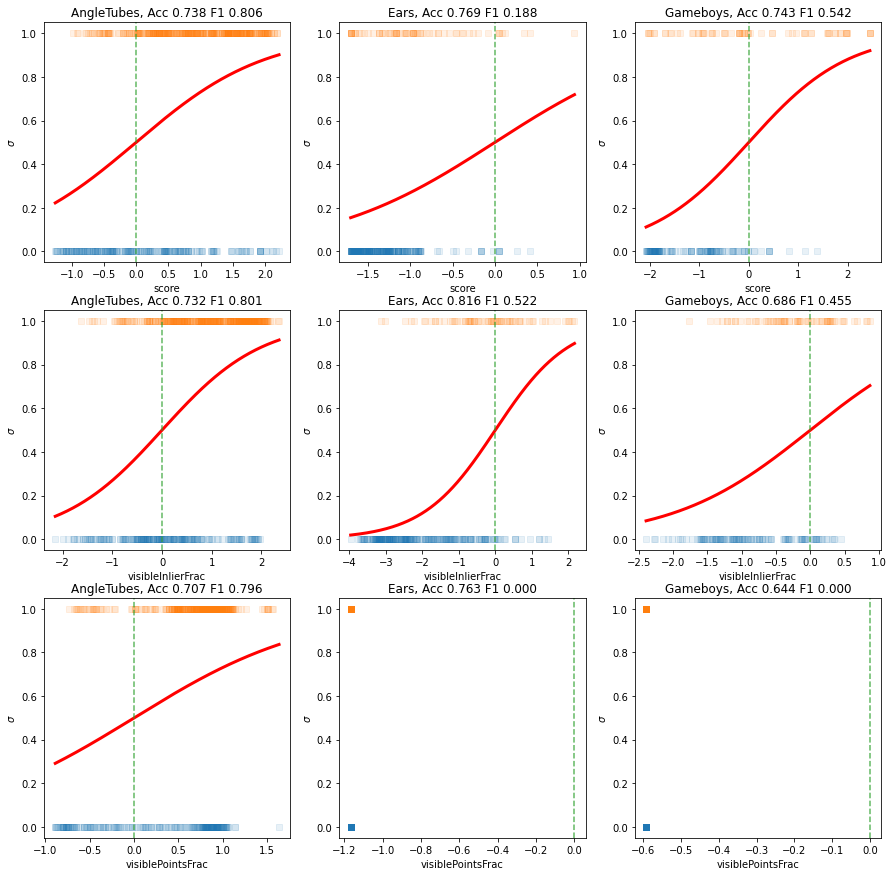

In [11]:
logistic_regression_plots_individual_factors(df,object_names = ["AngleTubes","Ears","Gameboys"], factors= ["score","visibleInlierFrac","visiblePointsFrac"],normalize_factors=False)
plt.savefig("PrObjectLogisticRegressionIndividual.pdf")
plt.savefig("PrObjectLogisticRegressionIndividual.png")
plt.show()

## Logistic Regression on Linear combination of Pr Object factors

In [12]:
models, result_df = binary_logistic_regession(df,["AngleTubes","Ears","Gameboys"],["score","visiblePointsFrac","visibleInlierFrac"],normalize_factors=False)
result_df

,objName,accuracy,precision,recall,f1,n_posetives,n_negatives,score_w,visiblePointsFrac_w,visibleInlierFrac_w
0,AngleTubes,0.748214,0.775132,0.839542,0.806052,349,211,0.047870,10.627260,3.875018
1,Ears,0.809365,0.652174,0.422535,0.512821,71,228,0.022774,6.963159,6.054504
2,Gameboys,0.774869,0.755102,0.544118,0.632479,68,123,0.055465,6.419216,3.667432


In [13]:
for k in models:
    print(k,models[k].intercept_)

AngleTubes [-6.7443988]
Ears [-8.30705382]
Gameboys [-7.85171304]


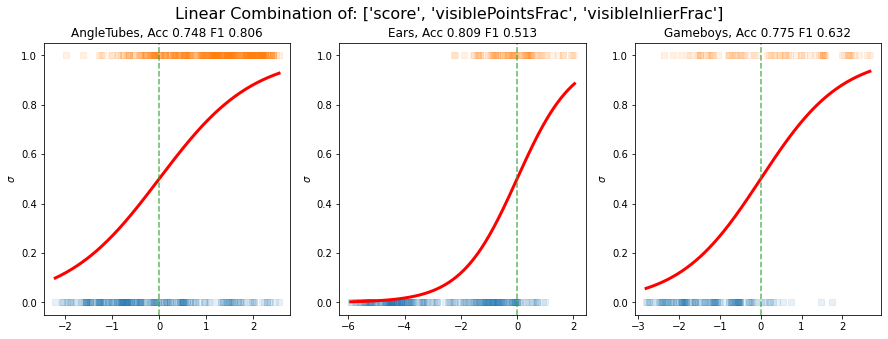

In [14]:
logistic_regression_plots(df,object_names = ["AngleTubes","Ears","Gameboys"], factors= ["score","visiblePointsFrac","visibleInlierFrac"],normalize_factors=False)
plt.savefig("PrObjectLogisticRegression.pdf")
plt.savefig("PrObjectLogisticRegression.png")
plt.show()

## Logistic Regression on Linear combination of Pr Object factors and Global factors

In [15]:
models, result_df = binary_logistic_regession(df,["AngleTubes","Ears","Gameboys"],["score","visiblePointsFrac","visibleInlierFrac","penetration","intersectingInliersFrac"],normalize_factors=False)
result_df

,objName,accuracy,precision,recall,f1,n_posetives,n_negatives,score_w,visiblePointsFrac_w,visibleInlierFrac_w,penetration_w,intersectingInliersFrac_w
0,AngleTubes,0.773214,0.784615,0.876791,0.828146,349,211,0.047962,17.950763,2.699035,0.097765,-19.035422
1,Ears,0.862876,0.734375,0.661972,0.696296,71,228,0.041240,8.881233,6.927662,-0.759511,-6.701556
2,Gameboys,0.780105,0.760000,0.558824,0.644068,68,123,0.071088,0.088877,0.464509,-0.645241,-0.582367


In [16]:
for k in models:
    print(k,models[k].intercept_)

AngleTubes [-8.27812791]
Ears [-9.29228452]
Gameboys [-2.69206493]


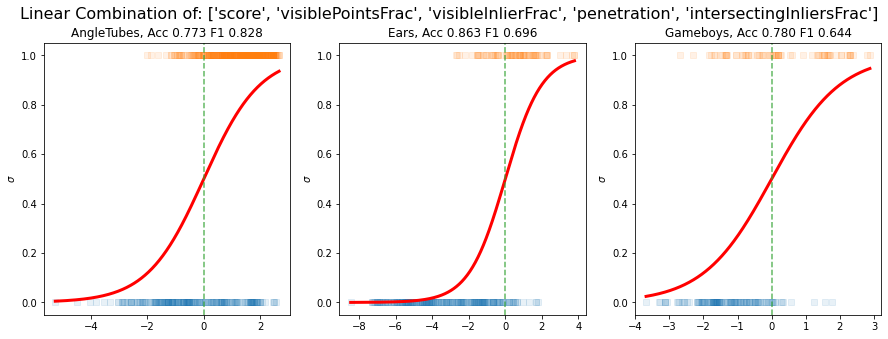

In [17]:
logistic_regression_plots(df,object_names = ["AngleTubes","Ears","Gameboys"], factors= ["score","visiblePointsFrac","visibleInlierFrac","penetration","intersectingInliersFrac"],normalize_factors=False)
plt.savefig("PrObjectLogisticRegressionWGlobalInfo.pdf")
plt.savefig("PrObjectLogisticRegressionWGlobalInfo.png")
plt.show()